# Imports, data class and other helping methods

In [1]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import os
from IPython.display import clear_output


from sklearn.ensemble import RandomForestRegressor

In [2]:
# Loads and prepares the data.
# Data can be accessed over class variables: train_input_FOCI, train_target_FOCI, validation_input_FOCI...
# Unprocessed data is saved. When seq_length or feature_list are None, they are not used.
# Data is processed to have 0 mean and 1 std.
# possible_features variable contains list with all feature names, even those that have not been selected.
# For lead_time = 0, the sequences currently DO NOT contain previous prec_sahel values.
# flatten_seq = False means that each sample consits of the arrays for each time step (e.g. [t1, t2, ...])
# flatten_seq = True means that each sample contains all the values of the time steps. (array containing values vs array containing arrays of values)
class Data:
  # Split = [train,validation, test], lead_time >= 0, seq_length > 0 or None, feature_list None or list of feature names
  def __init__(self, split = [0.9, 0.0, 0.1], lead_time = 0, seq_length=None, flatten_seq=False, feature_list=None, retain_order_after_selection=True):
    # Variables
    self.possible_features = [] # Filled later on to track all possible features before selection
    self.current_features = [] # Filled later to track selected features
    self.__data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2023.03.29.1/climate_indices.csv"
    )

    # Load the data
    FOCI, CESM = self.__load_data()

    # Split into input and target
    input_FOCI, target_FOCI = self.__get_input_target(FOCI, lead_time)
    input_CESM, target_CESM = self.__get_input_target(CESM, lead_time)

    # Save possible features that can be selected
    self.possible_features = list(input_FOCI.columns)
    
    # Sort the features of the feature list to be in the same order as the original features
    # this is needed for consistency when selecting features since different feature orders can result
    # in different performance.
    if retain_order_after_selection and feature_list is not None:
        selection = [feature for feature in self.possible_features if feature in feature_list]
    
    # Select features if any are set
    input_FOCI = input_FOCI if feature_list is None else input_FOCI[selection]
    input_CESM = input_CESM if feature_list is None else input_CESM[selection]

    # Save selected features
    self.current_features = list(input_FOCI.columns)

    # Split into train, validation and test, based on split percentage given
    self.train_input_FOCI, self.validation_input_FOCI, self.test_input_FOCI = self.__get_train_validation_test(input_FOCI, split)
    self.train_target_FOCI, self.validation_target_FOCI, self.test_target_FOCI = self.__get_train_validation_test(target_FOCI, split)

    self.train_input_CESM, self.validation_input_CESM, self.test_input_CESM = self.__get_train_validation_test(input_CESM, split)
    self.train_target_CESM, self.validation_target_CESM, self.test_target_CESM = self.__get_train_validation_test(target_CESM, split)

    # Fit standardscaler on trainings data and then scale train, validation and test input with it to obtain 0 mean and 1 std
    # Returned values are numpy arrays
    self.train_input_FOCI, self.validation_input_FOCI, self.test_input_FOCI = self.__scale_data(self.train_input_FOCI, self.validation_input_FOCI, self.test_input_FOCI)
    self.train_input_CESM, self.validation_input_CESM, self.test_input_CESM = self.__scale_data(self.train_input_CESM, self.validation_input_CESM, self.test_input_CESM)

    # Do the same with the target data
    self.train_target_FOCI, self.validation_target_FOCI, self.test_target_FOCI = self.__scale_data(self.train_target_FOCI, self.validation_target_FOCI, self.test_target_FOCI)
    self.train_target_CESM, self.validation_target_CESM, self.test_target_CESM = self.__scale_data(self.train_target_CESM, self.validation_target_CESM, self.test_target_CESM)

    # Turn target arrays into 1D arrays, reshape only if array actually exists
    # otherwise an error would be thrown.
    if len(self.train_target_FOCI) > 0:
      self.train_target_FOCI = self.train_target_FOCI.reshape(-1)
      self.train_target_CESM = self.train_target_CESM.reshape(-1)
    if len(self.validation_target_FOCI) > 0:
      self.validation_target_FOCI = self.validation_target_FOCI.reshape(-1)
      self.validation_target_CESM = self.validation_target_CESM.reshape(-1)
    if len(self.test_target_FOCI) > 0:
      self.test_target_FOCI = self.test_target_FOCI.reshape(-1)
      self.test_target_CESM = self.test_target_CESM.reshape(-1)

    # Turn data into sequences consisting of seq_length timesteps
    if seq_length is not None:
      # Check for valid seq_length
      if seq_length <= 0:
        raise ValueError('seq_length has to be an integer > 0 or None but is{}'.format(seq_length))

      # Train FOCI
      if len(self.train_input_FOCI) > 0:
        self.train_input_FOCI, self.train_target_FOCI = self.__into_sequence(self.train_input_FOCI, self.train_target_FOCI, seq_length, flatten_seq)
      # Validation FOCI
      if len(self.validation_input_FOCI) > 0:
        self.validation_input_FOCI, self.validation_target_FOCI = self.__into_sequence(self.validation_input_FOCI, self.validation_target_FOCI, seq_length, flatten_seq)
      # Test FOCI
      if len(self.test_input_FOCI) > 0:
        self.test_input_FOCI, self.test_target_FOCI = self.__into_sequence(self.test_input_FOCI, self.test_target_FOCI, seq_length, flatten_seq)
      # Train CESM
      if len(self.train_input_CESM) > 0:
        self.train_input_CESM, self.train_target_CESM = self.__into_sequence(self.train_input_CESM, self.train_target_CESM, seq_length, flatten_seq)
      # Validation CESM
      if len(self.validation_input_CESM) > 0:
        self.validation_input_CESM, self.validation_target_CESM = self.__into_sequence(self.validation_input_CESM, self.validation_target_CESM, seq_length, flatten_seq)
      # Test CESM
      if len(self.test_input_CESM) > 0:
        self.test_input_CESM, self.test_target_CESM = self.__into_sequence(self.test_input_CESM, self.test_target_CESM, seq_length, flatten_seq)


  # Loads the data from url or disk, returns FOCI, CESM as pandas dataframes.
  def __load_data(self):
    # Check if data exists on disk, if so load from disk, otherwise from url
    if os.path.exists('climate_indices.csv'):
      climind = pd.read_csv('climate_indices.csv')
    else:
      climind = pd.read_csv(self.__data_url)
      # Save data to disk
      climind.to_csv('climate_indices.csv', index=False)

    # Split into FOCI and CESM
    climind = climind.set_index(["model", "year", "month", "index"]).unstack(level=-1)["value"]
    FOCI = climind.loc[('FOCI')].reset_index().drop(columns=['year','month'])
    CESM = climind.loc[('CESM')].reset_index().drop(columns=['year','month'])

    # Return them
    return FOCI, CESM

  # Takes the FOCI or CESM pandas dataframe and returns the input and target
  # Input and target depends on the lead_time, for lead_time >0 input contains
  # PREC_SAHEL of the current time step, for lead_time = 0 it does not.
  # lead_time determines how many months in advance the target is.
  def __get_input_target(self, data, lead_time):
    # Check if lead_time is vlaid
    if lead_time < 0:
      raise ValueError('lead_time has to have a value >= 0 but has value {}'.format(self.__lead_time))

    # Split into target and input, input has to omit the last lead_time elements or there would be no target for them
    target = data.loc[:,data.columns == 'PREC_SAHEL']
    input = data.loc[:,data.columns != 'PREC_SAHEL'] if lead_time == 0 else data[:-lead_time]

    # Adjust target for lead_time if needed
    if lead_time > 0:
      target = target[lead_time:]

    # Return input and target
    return input, target

  # Splits data based on the given split into train, validation and test
  # split = [train, validation, test] as decimal indicating percentage
  def __get_train_validation_test(self, data, split):
    # Check if split is valid
    if sum(split) != 1 or split[0] <= 0 or any(i < 0 for i in split):
      raise ValueError('Invalid split has been passed. Values can be negative, have to sum up to 1 and train has to be > 0')

    # Get number of samples for each split
    n_train = int(split[0] * len(data))
    n_val = int(split[1] * len(data))
    n_test = int(split[2] * len(data))  # Only used to check if there is a test set

    # Create the splits
    train = data[:n_train] if n_train > 0 else []
    val =  data[n_train:n_train+n_val] if n_val > 0 else []
    test = data[n_train+n_val:] if n_test > 0 else []

    # Return them
    return train, val, test

  # Scales the data to have mean of 0 and std of 1
  # only fits on the training input data
  def __scale_data(self, train, val, test):
    scaler = StandardScaler()
    scaler.fit(train)

    # Transform train, val, test input to have 0 mean and 1std
    # only perform transformation if set is non empty
    scaled_train = scaler.transform(train) if len(train) > 0 else []
    scaled_val = scaler.transform(val) if len(val) > 0 else []
    scaled_test = scaler.transform(test) if len(test) > 0 else []

    return scaled_train, scaled_val, scaled_test

  # Turns input into a sequence consisting of seq_length time steps
  # and selects i+seq_length-1 as the corresponding target index for the i'th sequence.
  def __into_sequence(self, input, target, seq_length, flatten_seq):
    input_seq = np.array([input[i:i+seq_length] for i in range(len(input)-seq_length)])
    target_seq = np.array([target[i+seq_length-1] for i in range(len(target)-seq_length)])

    # Flatten sample containing the sequences if wanted (sample = [t_0, t_1,...] with t_0 = [feature_1, feature_2,...])
    if flatten_seq:
      input_seq = [seq.reshape(-1) for seq in input_seq]

    return input_seq, target_seq

In [11]:
# Trains random forest and returns mse on validation set (for FOCI)
def train_and_evaluate_randomforest(model, data):
  # Train random forest
  print('Training random forest...')
  model.fit(data.train_input_FOCI, data.train_target_FOCI)

  # Get validation loss
  print('Evaluating...')
  predicted = model.predict(data.validation_input_FOCI)
  mse = mean_squared_error(data.validation_target_FOCI, predicted)
  corr = np.corrcoef(data.validation_target_FOCI, predicted)[0,1]
  print('MSE: {}'.format(mse))
  print('Corr: {}'.format(corr))

  return mse, corr

In [4]:
# Plots feature importance, in case of seq_length > 1 the feature_importance for a feature is summed up over all time steps
def plot_feature_importance(model, data):
  feature_names = data.current_features

  # Get feature importance with their corresponding names and sort in descending order.
  # If there are multiple timesteps, sum a feature up over all time steps
  foci_feature_importance = model.feature_importances_
  per_feature = {}

  for idx, value in enumerate(foci_feature_importance):
    name = feature_names[idx % len(feature_names)]

    if per_feature.get(name) is None:
      per_feature[name] = value
    else:
      per_feature[name] += value

  foci_feature_importance = [(name, value) for (name, value) in zip(per_feature.keys(), per_feature.values())]
  foci_feature_importance = sorted(foci_feature_importance, key=lambda feature: feature[1], reverse=True)

  # Plot them
  plt.figure(figsize=(20, 3))
  plt.bar([value for (value, name) in foci_feature_importance], [name for (value, name) in foci_feature_importance])
  plt.xlabel('Feature')
  plt.ylabel('Feature importance')
  plt.xticks(rotation=90, ha='right')
  plt.show()

In [5]:
def train_random_forest_and_plot(seq_length, num_trees):
  data = Data(split=[0.8, 0.1, 0.1], flatten_seq=True, seq_length=seq_length)
  model = RandomForestRegressor(n_estimators=num_trees, random_state=0)
  mse, corr = train_and_evaluate_randomforest(model, data)
  plot_feature_importance(model, data)

In [6]:
def plot_feature_importance_per_month(model, data):
  foci_feature_importance = model.feature_importances_
  monthly_feature_importance = []
  num_features = len(data.current_features)

  for i in range(0, len(foci_feature_importance), num_features):
    monthly_feature_importance.append(sum(foci_feature_importance[i:i+num_features]))

  months = [str(i) for i in range(len(monthly_feature_importance))]
  months.reverse()  # Reverse them so that the month closest to the prediction has the label 0

  plt.bar(months, monthly_feature_importance) # List representing months is reversed so that it represents how many months we are away from the current time step
  plt.xlabel('Month')
  plt.ylabel('Feature importance')
  plt.show()

In [7]:
# Takes a random forest model and an instance of the data class, returns (name, value) pairs representing
# the feature importance for all features.
def get_total_feature_ranking(model, data, descending=True):
  feature_importances = model.feature_importances_
  feature_names = data.current_features
  per_feature = {}

  for idx, value in enumerate(feature_importances):
    name = feature_names[idx % len(feature_names)]
    per_feature[name] = value if per_feature.get(name) is None else per_feature[name] + value

  feature_ranking = [(name, value) for (name, value) in zip(per_feature.keys(), per_feature.values())]
  feature_ranking = sorted(feature_ranking, key=lambda feature: feature[1], reverse=descending)

  return feature_ranking

# Feature ranking changes over different sequence lengths

Training random forest...
Evaluating...
MSE: 0.7996301655140295


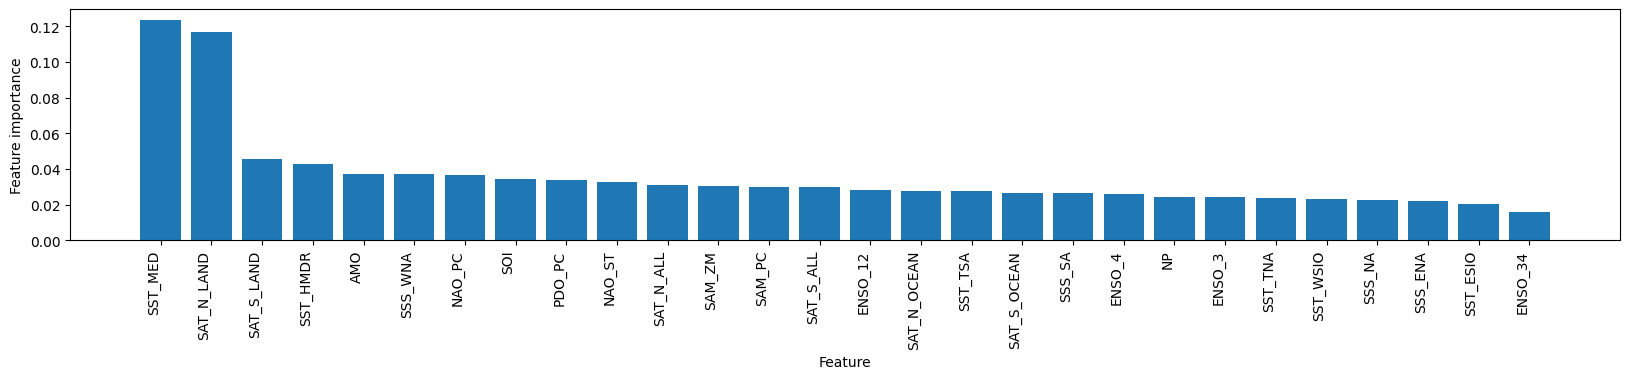

Training random forest...
Evaluating...
MSE: 0.7675415371669595


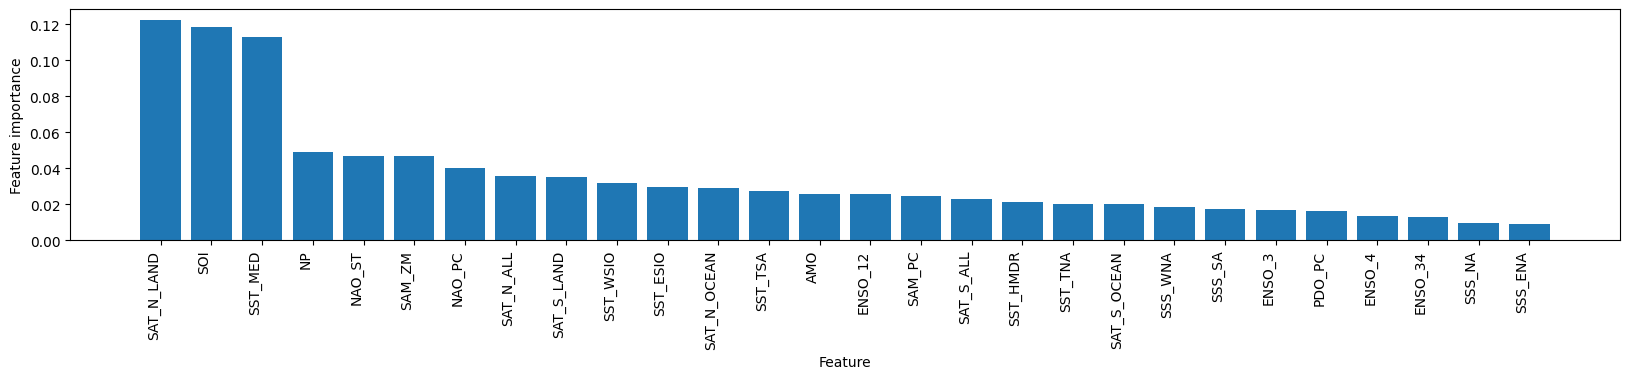

In [ ]:
# Lets compare feature importance of diffrent sequence lengths
train_random_forest_and_plot(seq_length=1, num_trees=100)
train_random_forest_and_plot(seq_length=12, num_trees=100)

# Current month is most important, but importances changes with lead time

In [10]:
# Settings
seq_length = 12
num_trees = 100

Lead time 0
Training random forest...
Evaluating...
MSE: 0.7582263451851543


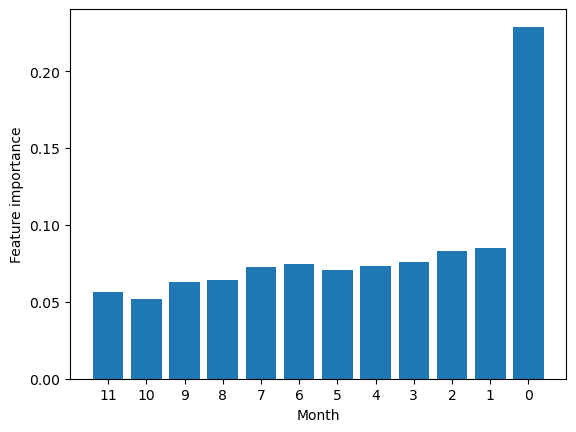

Lead time 1
Training random forest...
Evaluating...
MSE: 0.9349658591685631


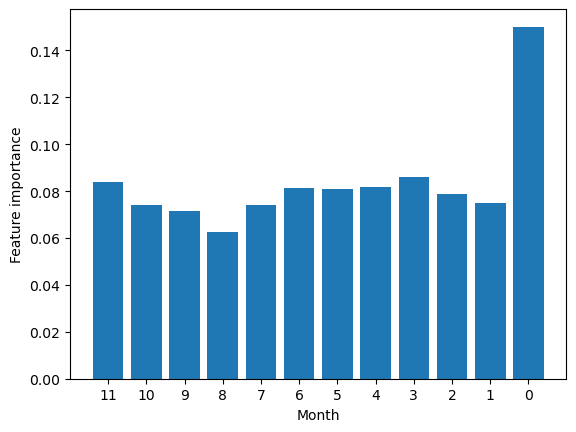

In [9]:
print('Lead time 0')
data = Data(split=[0.8, 0.1, 0.1], flatten_seq=True, seq_length=seq_length, lead_time=0)
model = RandomForestRegressor(n_estimators=num_trees, random_state=0, n_jobs=-1)
mse, corr = train_and_evaluate_randomforest(model, data)
plot_feature_importance_per_month(model, data)

print('Lead time 1')
data = Data(split=[0.8, 0.1, 0.1], flatten_seq=True, seq_length=seq_length, lead_time=1)
model = RandomForestRegressor(n_estimators=num_trees, random_state=0, n_jobs=-1)
mse, corr = train_and_evaluate_randomforest(model, data)
plot_feature_importance_per_month(model, data)

Lead time 3
Training random forest...
Evaluating...
MSE: 0.9869284912203126


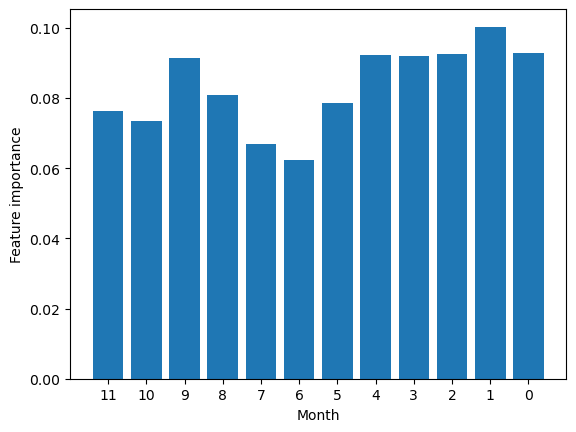

In [11]:
print('Lead time 3')
data = Data(split=[0.8, 0.1, 0.1], flatten_seq=True, seq_length=seq_length, lead_time=3)
model = RandomForestRegressor(n_estimators=num_trees, random_state=0, n_jobs=-1)
mse, corr = train_and_evaluate_randomforest(model, data)
plot_feature_importance_per_month(model, data)

# Finding a sequence length
## Based on MSE
Optimal sequence length might be larger but the runtime quickly explodes when using random forests.
### Lead time = 0
sequence length = 9, FOCI MSE = 0.7368

[(0.8007933771285888, '1'), (0.7709968121163093, '2'), (0.7652879688366666, '3'), (0.7494472040799699, '4'), (0.7619672171210223, '5'), (0.7618937940186996, '6'), (0.7650155301385128, '7'), (0.7616143370501224, '8'), (0.7368237944763764, '9'), (0.7499753879118058, '10'), (0.75285757550256, '11'), (0.7582263451851543, '12'), (0.76269316270874, '13'), (0.7704898934187837, '14'), (0.7616400788217256, '15'), (0.7629997332823387, '16'), (0.7602649352195981, '17'), (0.7603172512134797, '18'), (0.7533898917527473, '19'), (0.7673999653936915, '20')]

### Lead time = 1
sequence length = 18, FOCI MSE = 0.9168

[(0.9455565602003703, '1'), (0.9373392208034843, '2'), (0.9459146411438796, '3'), (0.9364399091743658, '4'), (0.9539843167784715, '5'), (0.9373158251739673, '6'), (0.926438569194849, '7'), (0.9341213452357323, '8'), (0.9347321048678779, '9'), (0.9293766988917763, '10'), (0.9408507402541759, '11'), (0.9349658591685631, '12'), (0.9352543896541077, '13'), (0.9269825403308254, '14'), (0.9251206812228755, '15'), (0.9357441316702465, '16'), (0.9228921854812437, '17'), (0.9168769325531746, '18'), (0.9262418194367992, '19')]

### Lead time = 3
sequence length = 22, FOCI MSE = 0.9591

## Based con corrCoef
Lowering MSE resulted in a lower correlation coefficient which is an unwanted result.

### Lead time = 1

In [17]:
def find_sequence_lenght(lead_time=0, start_length=1, add_per_iteration=1, end_length=24, output_every_n_steps=1, num_trees=100, use_corr=False):
    curr_length = start_length -1
    performance_hist = []
    month_hist = []
    title_text = 'Corr over sequence length' if use_corr else 'MSE loss over sequence length'
    y_label_text = 'Corr' if use_corr else 'MSE'
    
    # Find sequence length
    while curr_length < end_length:
        # Update sequence length
        curr_length += 1

        # Train new model
        data = Data(split=[0.8, 0.1, 0.1], flatten_seq=True, seq_length=curr_length, lead_time=lead_time)
        model = RandomForestRegressor(n_estimators=num_trees, random_state=0, n_jobs=-1)
        mse, corr = train_and_evaluate_randomforest(model, data)
        performance = corr if use_corr else mse
        
        # Track performance
        performance_hist.append(performance)
        month_hist.append(str(curr_length))

        # Check if check point has been reached
        if curr_length % output_every_n_steps == 0:
            # Clear output first
            clear_output()
            # Output history
            result = list(zip(performance_hist, month_hist))
            print(result)
            
            # If so create plot
            plt.plot(month_hist, performance_hist)
            
            plt.title(title_text)
            plt.xlabel('Months')
            plt.ylabel(y_label_text)
            plt.show()
            # Min/Max
            print('Min: {}'.format(min(result, key = lambda t: t[0])))
            print('Max: {}'.format(max(result, key = lambda t: t[0])))
    
    # Output result
    clear_output()
    # Output history
    result = list(zip(performance_hist, month_hist))
    print(result)
    # Plot
    plt.plot(month_hist, performance_hist)
    plt.title(title_text)
    plt.xlabel('Months')
    plt.ylabel(y_label_text)
    plt.show()
    # Min/Max
    print('Min: {}'.format(min(result, key = lambda t: t[0])))
    print('Max: {}'.format(max(result, key = lambda t: t[0])))

[(0.4732635316674136, '1'), (0.503787804528713, '2'), (0.5127497409741861, '3'), (0.5314184807237188, '4'), (0.5204872056932914, '5'), (0.5203731413144352, '6'), (0.5098134133951654, '7'), (0.5130228557836417, '8'), (0.5415007872339151, '9'), (0.5277517780717434, '10'), (0.5243940654620919, '11'), (0.5189194843179735, '12')]


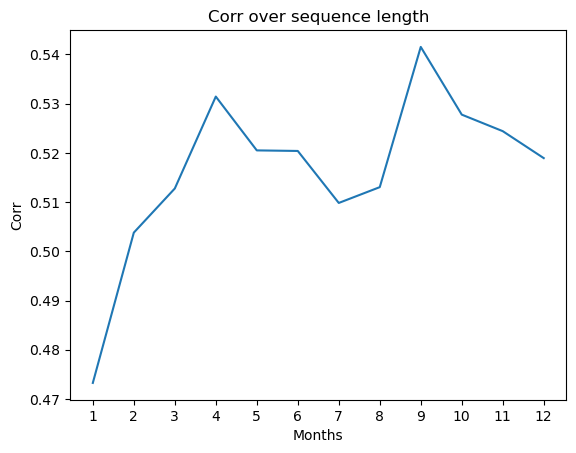

Min: (0.4732635316674136, '1')
Max: (0.5415007872339151, '9')
Training random forest...


KeyboardInterrupt: 

In [20]:
find_sequence_lenght(end_length=24, use_corr=True)

# Selecting Features
I will not use backward selection since forward selection already takes for ever and on lead_time=0 forward selection outperformed backward selection (even though with forward selection performing worse for lead_time = 3 it migh perform better)

## Forward selection

### Lead time =3
Result of forward selection: ['PREC_SAHEL', 'SOI', 'NP', 'NAO_ST', 'SST_WSIO', 'SST_MED', 'SST_ESIO', 'SAM_PC', 'ENSO_4']
Resulting MSE: 0.9692

Which successfully is worse than using all features. (0.969 vs 0.959)
When I used this before with a lead_time=0 it resulted in an improvement and in different features being selected.

### Lead time = 1
Selected features are: ['PREC_SAHEL', 'SOI', 'SST_MED', 'SAM_ZM', 'NAO_ST', 'NAO_PC', 'SAT_N_LAND', 'ENSO_4']
MSE with all features: 0.9168769325531746
MSE with seleczed features: 0.9155843599031653

### Lead time = 0
#### MSE based
Selected features are: ['SAT_N_LAND', 'SST_MED', 'SOI', 'NP', 'SAM_ZM', 'SST_ESIO', 'AMO', 'SST_TNA', 'SSS_ENA', 'SSS_NA']
MSE with all features: 0.7368237944763761
MSE with seleczed features: 0.7258788248916098
#### Corr based
Selected features are: ['SAT_N_LAND', 'SST_MED', 'SOI', 'NP', 'SAM_ZM', 'SST_HMDR', 'SSS_NA']
Corr with all features     : 0.541500787233915
Corr with selected features: 0.5439036440634155
MSE with selected features : 0.7346250155015768

In [24]:
def forward_selection(lead_time=0, seq_length=9, num_trees=100, use_corr=False):
    # Get feature ranking and min mse/max corr
    data = Data(split=[0.8, 0.1, 0.1], flatten_seq=True, seq_length=seq_length, lead_time=lead_time)
    best_model = RandomForestRegressor(n_estimators=num_trees, random_state=0, n_jobs=-1)
    init_mse, init_corr = train_and_evaluate_randomforest(best_model, data)
    feature_ranking = get_total_feature_ranking(best_model, data)
    min_mse = float('inf')
    max_corr = float('-inf')

    # Perform forward selection
    selection = []
    for (name, value) in feature_ranking:

        # Add new feature
        selection.append(name)
        data = Data(split=[0.8, 0.1, 0.1], flatten_seq=True, seq_length=seq_length, feature_list=selection, lead_time=lead_time)

        # Train model with selected features
        model = RandomForestRegressor(n_estimators=num_trees, random_state=0, n_jobs=-1)
        mse, corr =  train_and_evaluate_randomforest(model, data)
        
        # Performance check for correlation
        if use_corr and corr > max_corr:
            print('Selected feature: {}'.format(name))
            best_model = model # Save model so we avoid retraining it for results
            max_corr = corr
            min_mse = mse # Update Mse for final output
        # Performance check for MSE loss
        elif not use_corr and mse < min_mse:
            print('Selected feature: {}'.format(name))
            best_model = model  # Save model so that it does not have to be retrained at the end
            max_corr = corr # Update corr for final output
            min_mse = mse
        # No performance improvement
        else:
            print('Feature {} has not been selected.'.format(name))
            selection = selection[:-1]  # Remove feature from selection
    
    # Print out results
    data = Data(split=[0.8, 0.1, 0.1], flatten_seq=True, seq_length=seq_length, feature_list=selection, lead_time=lead_time)
    clear_output()
    print('Selected features: {}'.format(selection))
    print('All feature performance:\nMSE:{}\nCorr:{}'.format(init_mse, init_corr))
    print('Selected feature performance:\nMSE:{}\nCorr:{}'.format(min_mse, max_corr))
    plot_feature_importance_per_month(best_model, data)
    plot_feature_importance(best_model, data)

Selected features: ['SAT_N_LAND', 'SST_MED', 'SOI', 'NP', 'SAM_ZM', 'SST_HMDR', 'SSS_NA']
All feature performance:
MSE:0.7368237944763762
Corr:0.541500787233915
Selected feature performance:
MSE:0.7346250155015768
Corr:0.5439036440634155


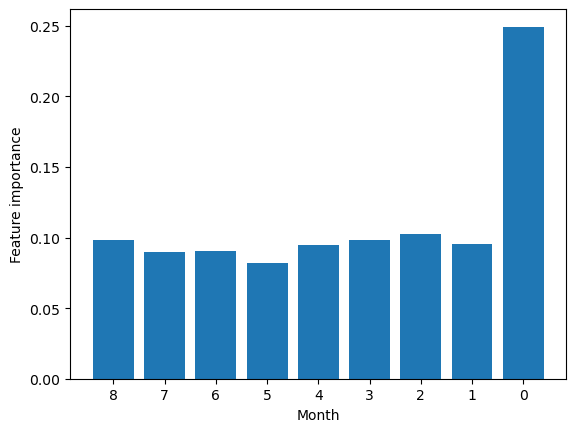

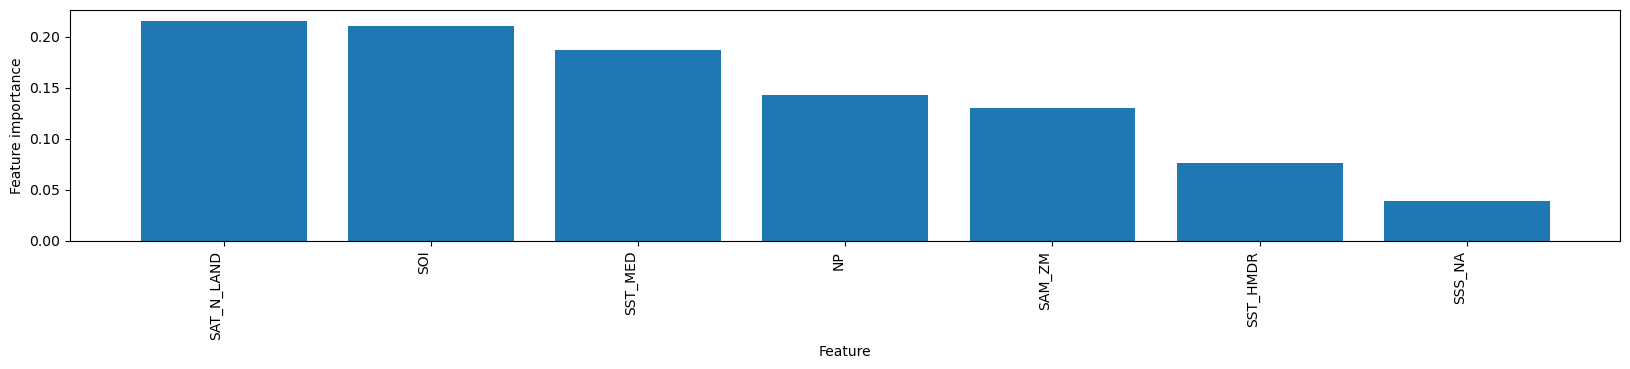

In [25]:
forward_selection(use_corr=True)

## Comparing all inputs RNN with feature selected RNN
Both the MSE and Corr based selection ended up with a worse performance than by simply using all features.
So I will not perform any selection of features.

### Imports and stuff needed for pytorch lstm

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Class used to store the data for pytorch
class RegressionDataset(Dataset):
    def __init__(self, input, target):
        self.input = torch.tensor(input, dtype=torch.float32)
        self.target = torch.tensor(target.reshape(-1,1), dtype=torch.float32)

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        x = self.input[idx]
        y = self.target[idx]
        return x, y
    
# Evalute a model using its made predictions and the expected ground truth
# todo: split into evaluation and visualisation
def evalute_predictions(predicted, ground_truth, text=''):
  mse = mean_squared_error(ground_truth, predicted)
  corr = np.corrcoef(ground_truth, predicted)[0,1]

  plt.scatter(ground_truth, predicted, label='MSE: {}\nCorr: {}'.format(mse, corr))
  x = np.linspace(*plt.xlim())
  plt.plot(x, x, linestyle='--', color='k', lw=2)

  plt.title(text)
  plt.xlabel('Target')
  plt.ylabel('Predicted')
  plt.legend()
  plt.show()

  return mse, corr

# Plots training and validation loss + adds a vertical line at lowest validation loss to show the selected model
def visualise_loss_history(training_loss_history, validation_loss_history, title='Training and Validation loss'):
  val, idx = min((val, idx) for (idx, val) in enumerate(validation_loss_history))
  plt.plot(training_loss_history, label='train_loss')
  plt.plot(validation_loss_history,label='val_loss')
  plt.axvline(x=idx, label='min val_loss', color='gray')
  plt.legend()
  plt.title(title)
  plt.show()

# Trains pytorch models and returns their train/validation loss history.
# Uses early stopping by restoring the weights of the model with the lowest validation loss after all epochs.
# Uses MSE loss and Adam optimizer
# Expects the model, the dataloader for the training, as well as the dataloader for the validation data.
# epochs, and learning rate are adjustable.
# learning rate: 0.025
def train_pytorch_network(model, train_dataloader, val_dataloader, num_epochs=200, learning_rate=0.001, weight_decay=0):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # Used to track loss
  train_loss_history = []
  validation_loss_history = []

  # Used for early stopping
  lowest_validation_loss = float('inf')
  best_model_weights = None

  # Train the model
  for epoch in range(num_epochs):
    # Reset loss and prepare model for training
    train_loss = 0.0
    model.train()
    # Train the model on all batches
    for i, (inputs, targets) in enumerate(train_dataloader):
      optimizer.zero_grad()
      out = model(inputs)
      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    # Adjust train loss for number of samples
    train_loss = train_loss / len(train_dataloader)

    # Calculate validation loss
    val_loss = 0.0
    model.eval()
    for i, (inputs, targets) in enumerate(val_dataloader):
      out = model(inputs)
      loss = criterion(out, targets)
      val_loss += loss.item()

    # Adjust val loss for number of samples
    val_loss = val_loss / len(val_dataloader)

    # Save train and validation loss of current epoch
    train_loss_history.append(train_loss)
    validation_loss_history.append(val_loss)

    # Save weights of the model with the best validation performance (early stopping)
    if val_loss <= lowest_validation_loss:
      best_model_weights = model.state_dict()

  # Restore the weights of the best model
  model.load_state_dict(best_model_weights)

  # Return loss history
  return train_loss_history, validation_loss_history

# Returns the predictions of the model for the given ground truth
def test_pytorch_network(model, input, target):
  dataset = RegressionDataset(input, target)
  dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

  # Prepare model
  model.eval()

  # Predict for the given input
  predictions = []
  ground_truth = []

  for (inputs, targets) in dataloader:
    pred = model(inputs).flatten()
    pred = pred.detach().numpy()
    predictions.append(pred)

    gt = targets.flatten()
    gt = gt.numpy()
    ground_truth.append(gt)

  # Get predictions and gt as a flat array
  predictions = np.concatenate(predictions)
  ground_truth = np.concatenate(ground_truth)

  return predictions, ground_truth

# Trains and evaluates the model, expects train, val and test split > 0
def train_and_evaluate_model(model, data, num_epochs=200, learning_rate=0.001, weight_decay=0):
  # Save untrained weights of model
  weights = model.state_dict()

  # FOCI dataset
  train_data_FOCI = RegressionDataset(data.train_input_FOCI, data.train_target_FOCI)
  val_data_FOCI = RegressionDataset(data.validation_input_FOCI, data.validation_target_FOCI)
  test_data_FOCI = RegressionDataset(data.test_input_FOCI, data.test_target_FOCI)

  # FOCI Dataloaders
  train_dataloader_FOCI = DataLoader(train_data_FOCI, batch_size=32, shuffle=True)
  val_dataloader_FOCI = DataLoader(val_data_FOCI, batch_size=32, shuffle=False)
  test_dataloader_FOCI = DataLoader(test_data_FOCI, batch_size=32, shuffle=False)

  # Train model on FOCI and visualise training
  train_hist, val_hist = train_pytorch_network(model, train_dataloader_FOCI, val_dataloader_FOCI, num_epochs=num_epochs, learning_rate=learning_rate, weight_decay=weight_decay)
  visualise_loss_history(train_hist, val_hist, title='Train and Val loss FOCI')

  # Test and visualise results
  predicted, ground_truth = test_pytorch_network(model, data.train_input_FOCI, data.train_target_FOCI)
  _, _ = evalute_predictions(predicted, ground_truth, text='Neural Network Regression FOCI train data')

  predicted, ground_truth = test_pytorch_network(model, data.test_input_FOCI, data.test_target_FOCI)
  mse_foci, corr_foci = evalute_predictions(predicted, ground_truth, text='Neural Network Regression FOCI test data')
  visualise_predictions_against_targtes(predicted, ground_truth)

  # Return test mse and corr
  return mse_foci, corr_foci


# Shows predicted values against target values
def visualise_predictions_against_targtes(predicted, target, title='Predictions vs Targets'):
  plt.figure(figsize=(20, 8))
  plt.bar(range(len(target)), target, label='Targets')
  plt.plot(predicted, label='Predictions', color='black')
  plt.legend()
  plt.title(title)
  plt.show()

In [57]:
class RNN(nn.Module):
    def __init__(self, num_in):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=num_in, hidden_size=28, num_layers=1, nonlinearity='relu', batch_first=True)
        self.fc1 = nn.Linear(28, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, 16)
        self.fc7 = nn.Linear(16, 16)
        self.fc8 = nn.Linear(16, 16)
        self.fc9 = nn.Linear(16, 8)
        self.fc10 = nn.Linear(8, 1)

        self.relu = nn.ReLU()

    def forward(self, x, h0=None):
        x, _ = self.rnn(x, h0)
        x = x[:,-1,:]
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.relu(self.fc8(x))
        x = self.relu(self.fc9(x))
        x = self.fc10(x)

        return x

## Unselected model

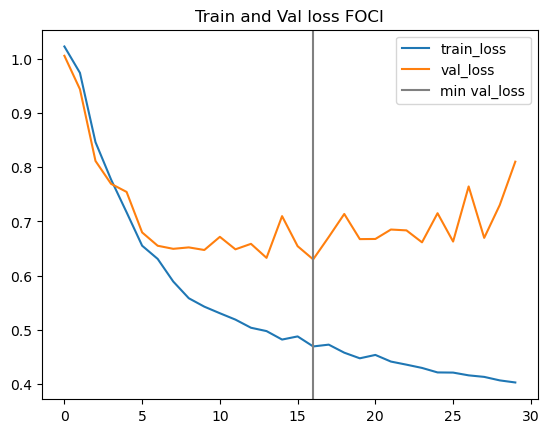

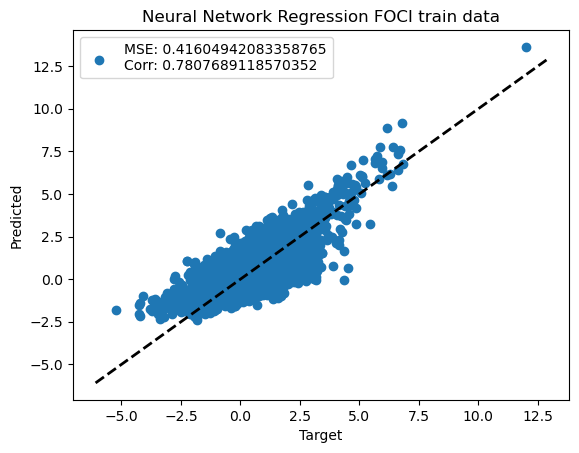

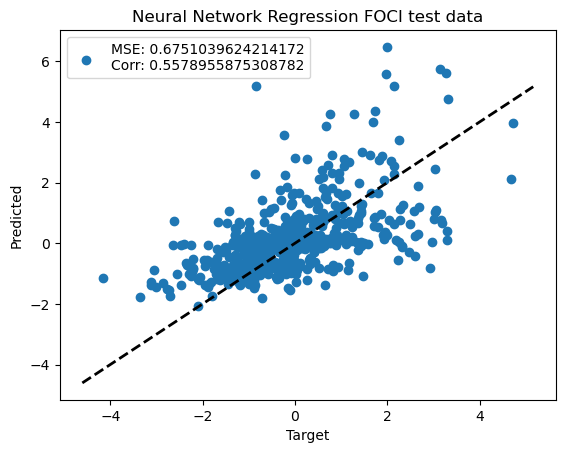

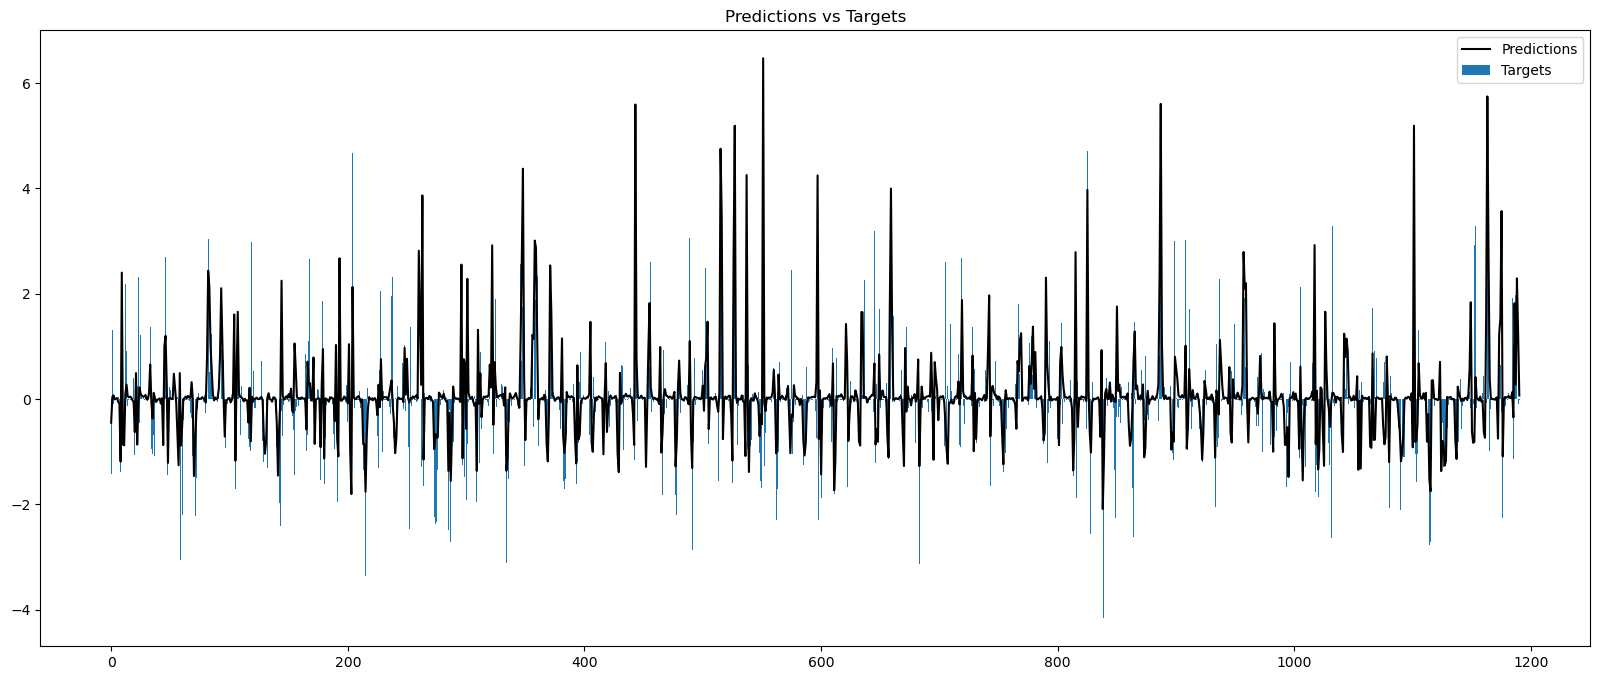

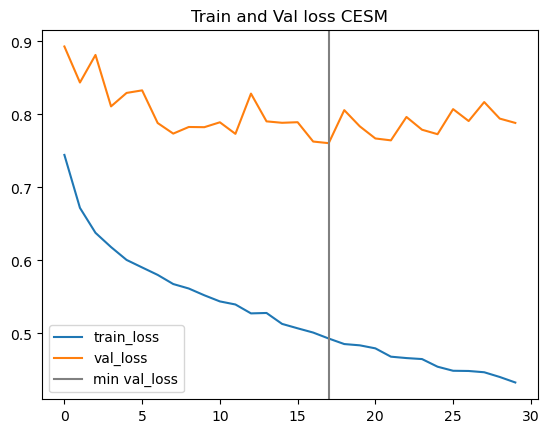

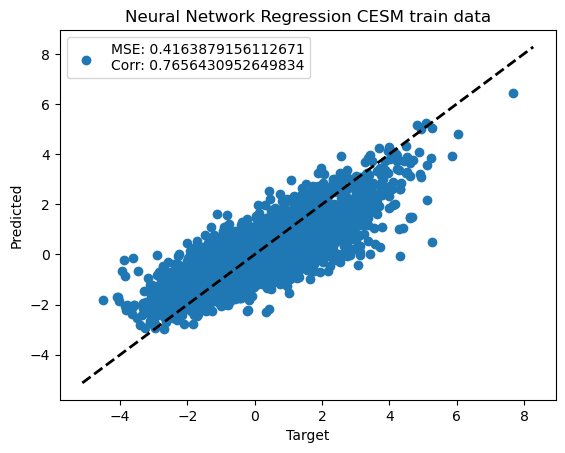

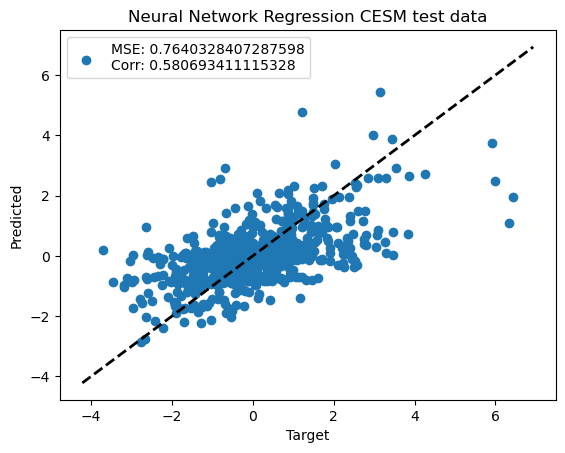

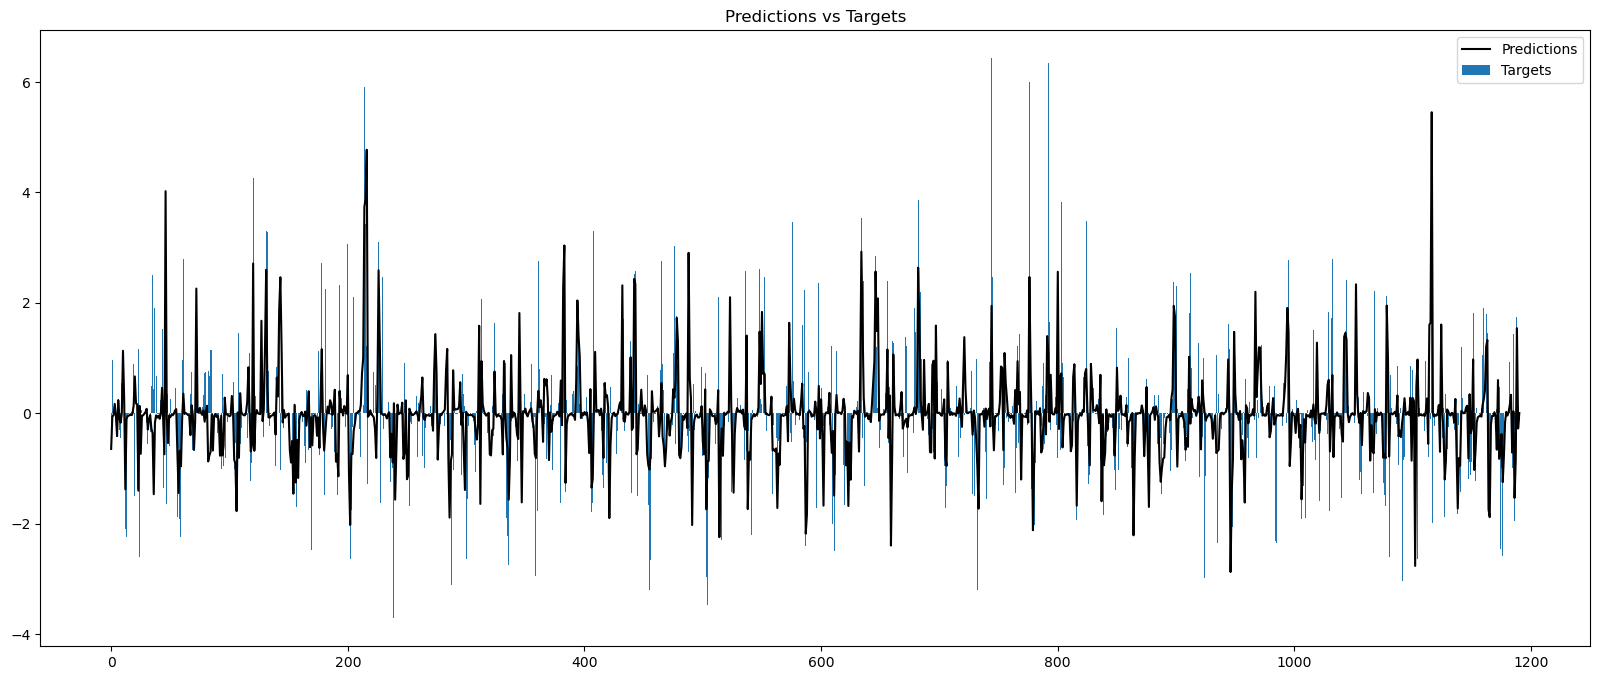

FOCI mse: 0.6751039624214172
 FOCI corr: 0.5578955875308782


In [30]:
torch.manual_seed(0)
lead_time = 0
seq_length = 9
flatten_seq = False
num_epochs = 30
learning_rate = 0.001
weight_decay = 0

# All features
data = Data(split=[0.8, 0.1, 0.1], lead_time=lead_time, seq_length=seq_length, flatten_seq=flatten_seq)
input_len = len(data.train_input_FOCI[0]) if flatten_seq else len(data.train_input_FOCI[0][0]) 
model = RNN(input_len)
mse_foci, corr_foci = train_and_evaluate_model(model, data, num_epochs=num_epochs, learning_rate=learning_rate, weight_decay=weight_decay)

print('FOCI mse: {}\n FOCI corr: {}'.format(mse_foci, corr_foci))

## MSE based selection
Resulted in lower MSE (0.6751039624214172 vs 0.6631799936294556) but also in way lower correlation (0.5578955875308782 vs 0.49178357035314746) which is undesired behaviour

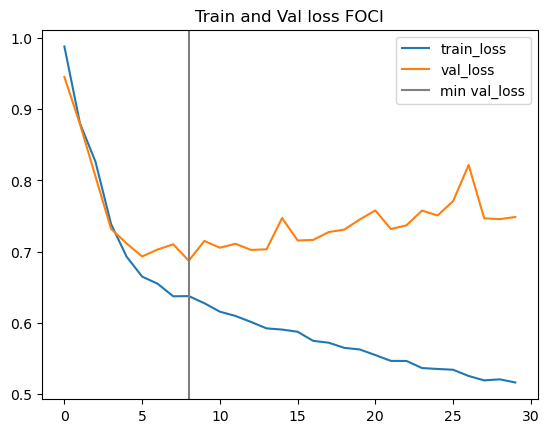

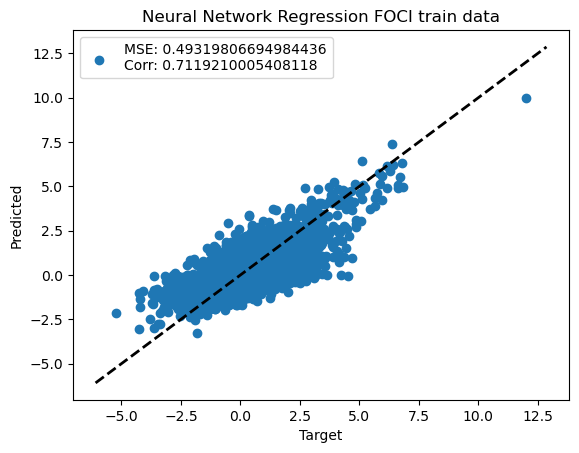

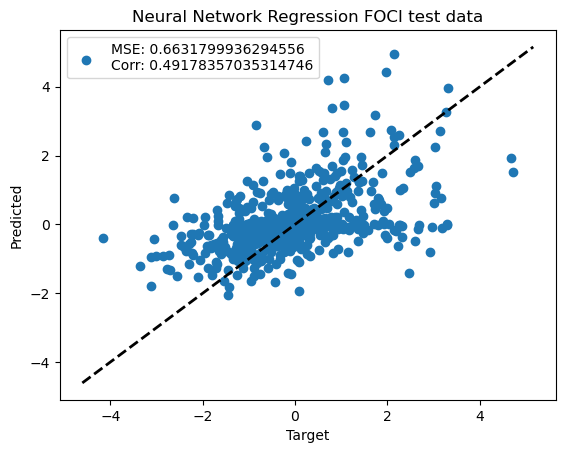

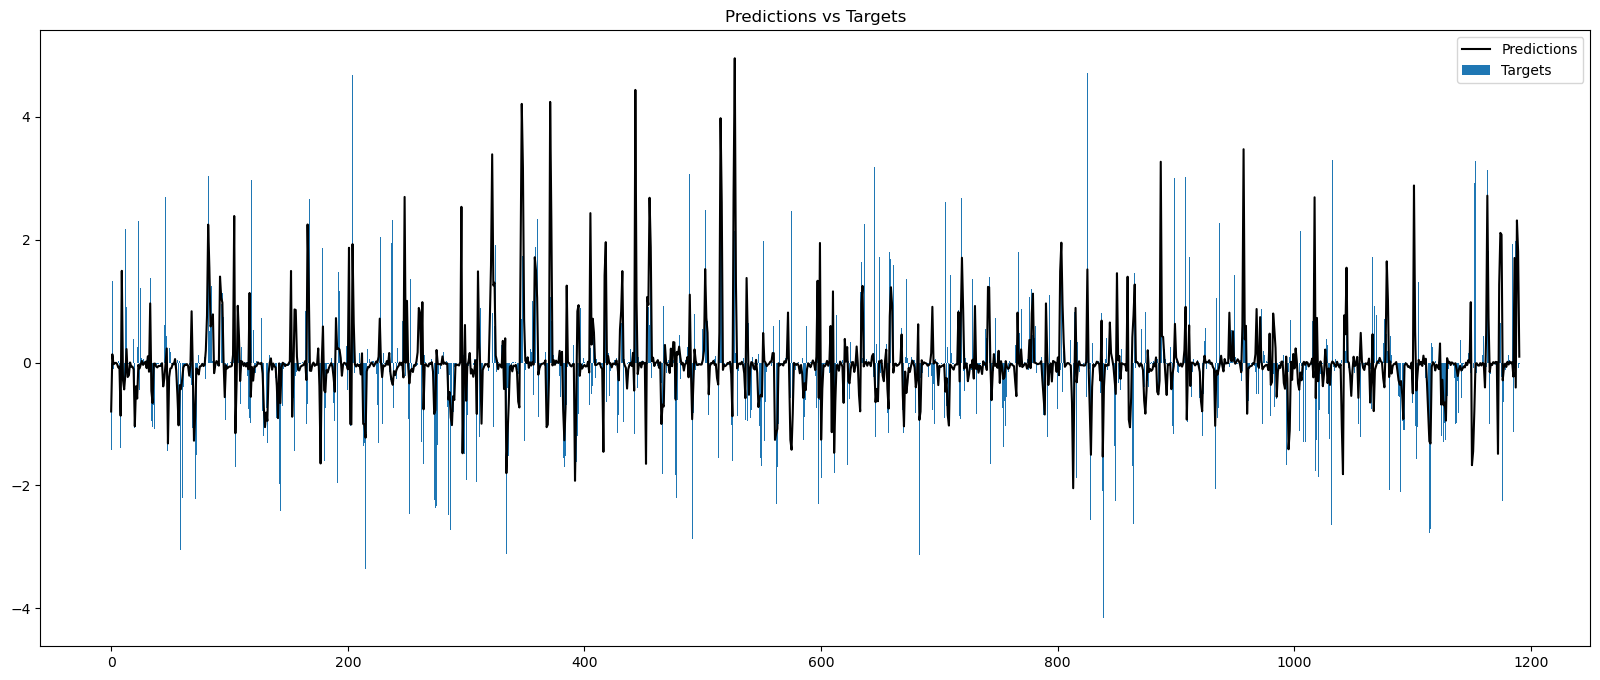

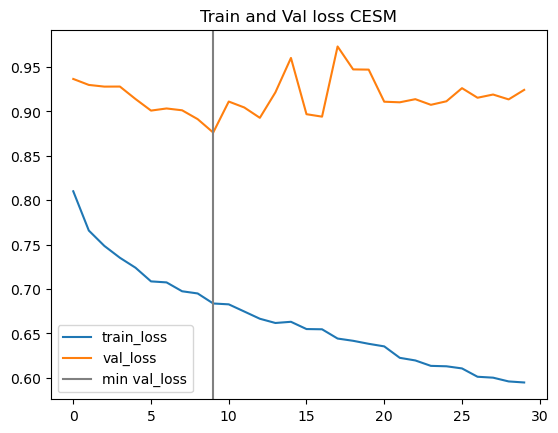

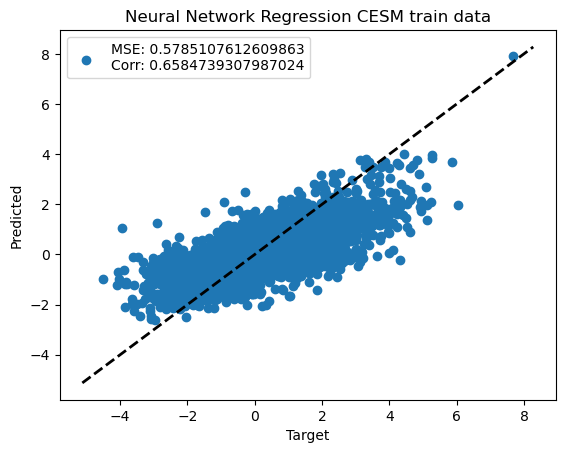

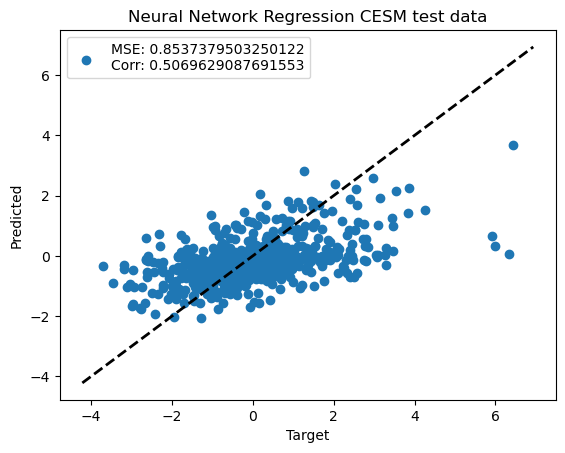

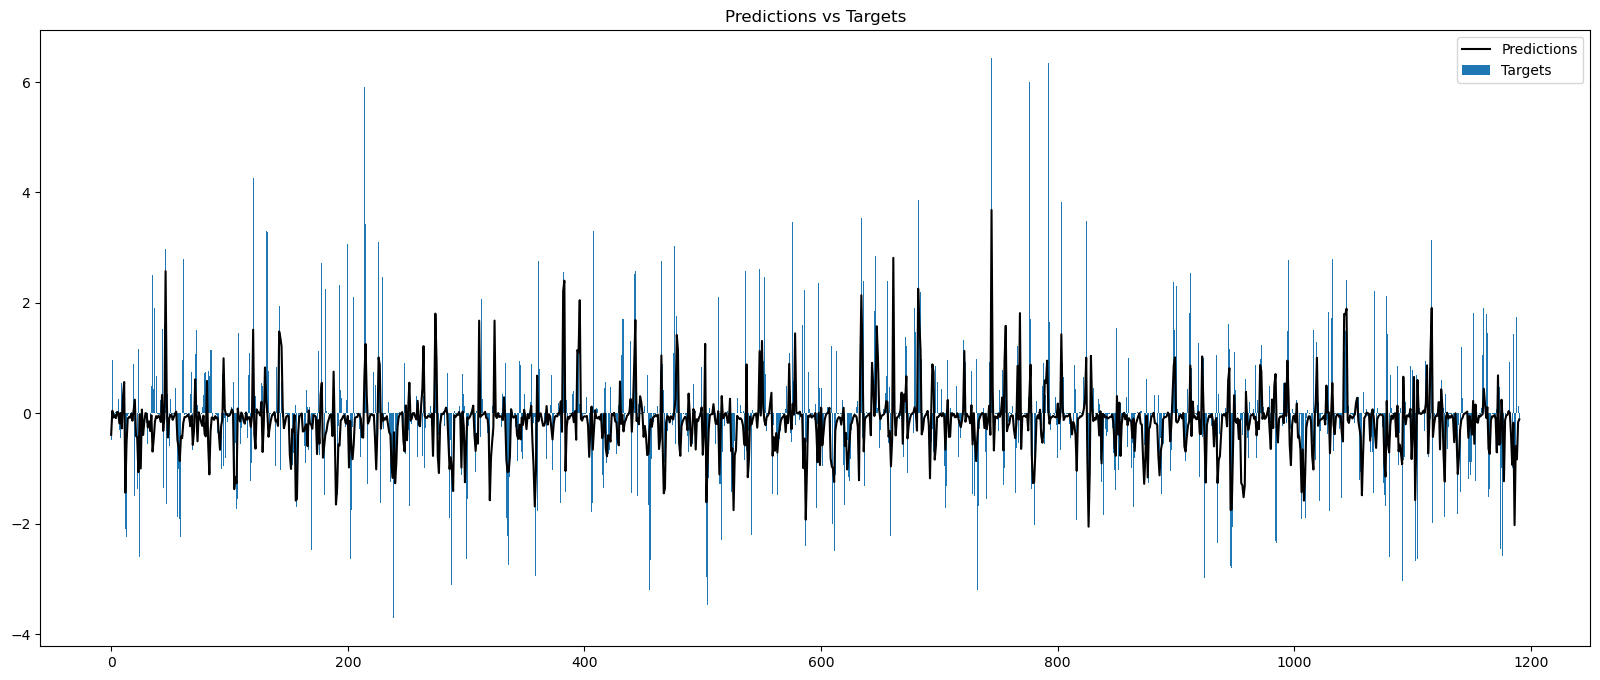

FOCI mse: 0.6631799936294556
 FOCI corr: 0.49178357035314746


In [31]:
# Features
selected = ['SAT_N_LAND', 'SST_MED', 'SOI', 'NP', 'SAM_ZM', 'SST_ESIO', 'AMO', 'SST_TNA', 'SSS_ENA', 'SSS_NA']

torch.manual_seed(0)


data = Data(split=[0.8, 0.1, 0.1], lead_time=lead_time, seq_length=seq_length, flatten_seq=False, feature_list=selected)
input_len = len(data.train_input_FOCI[0]) if flatten_seq else len(data.train_input_FOCI[0][0]) 
model = RNN(input_len)
mse_foci, corr_foci = train_and_evaluate_model(model, data, num_epochs=num_epochs, learning_rate=learning_rate, weight_decay=weight_decay)

print('FOCI mse: {}\n FOCI corr: {}'.format(mse_foci, corr_foci))

## Corr based selection
Even the correlation based selection ends up with an even lower correlation (0.5578955875308782 vs 0.49178357035314746 vs )

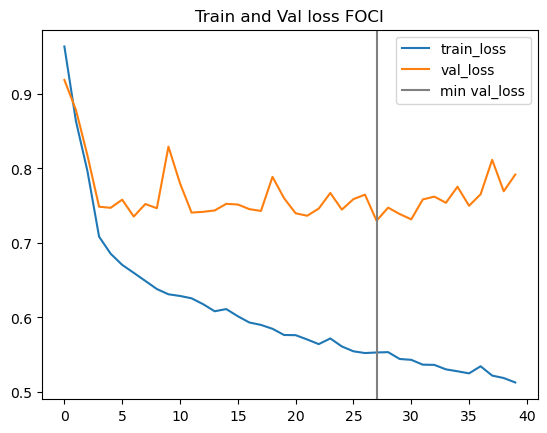

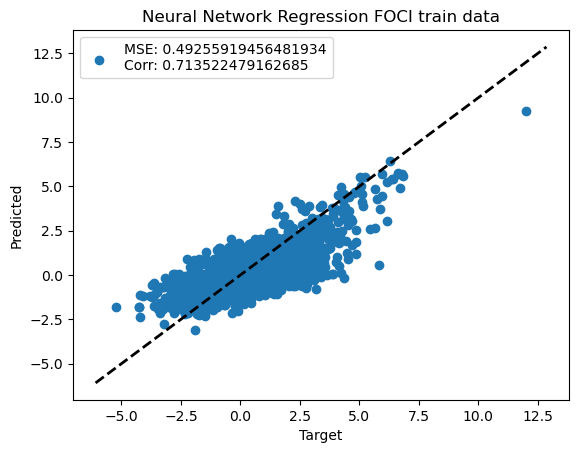

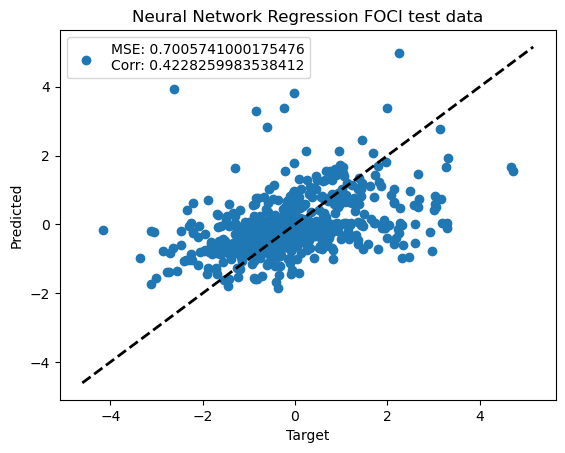

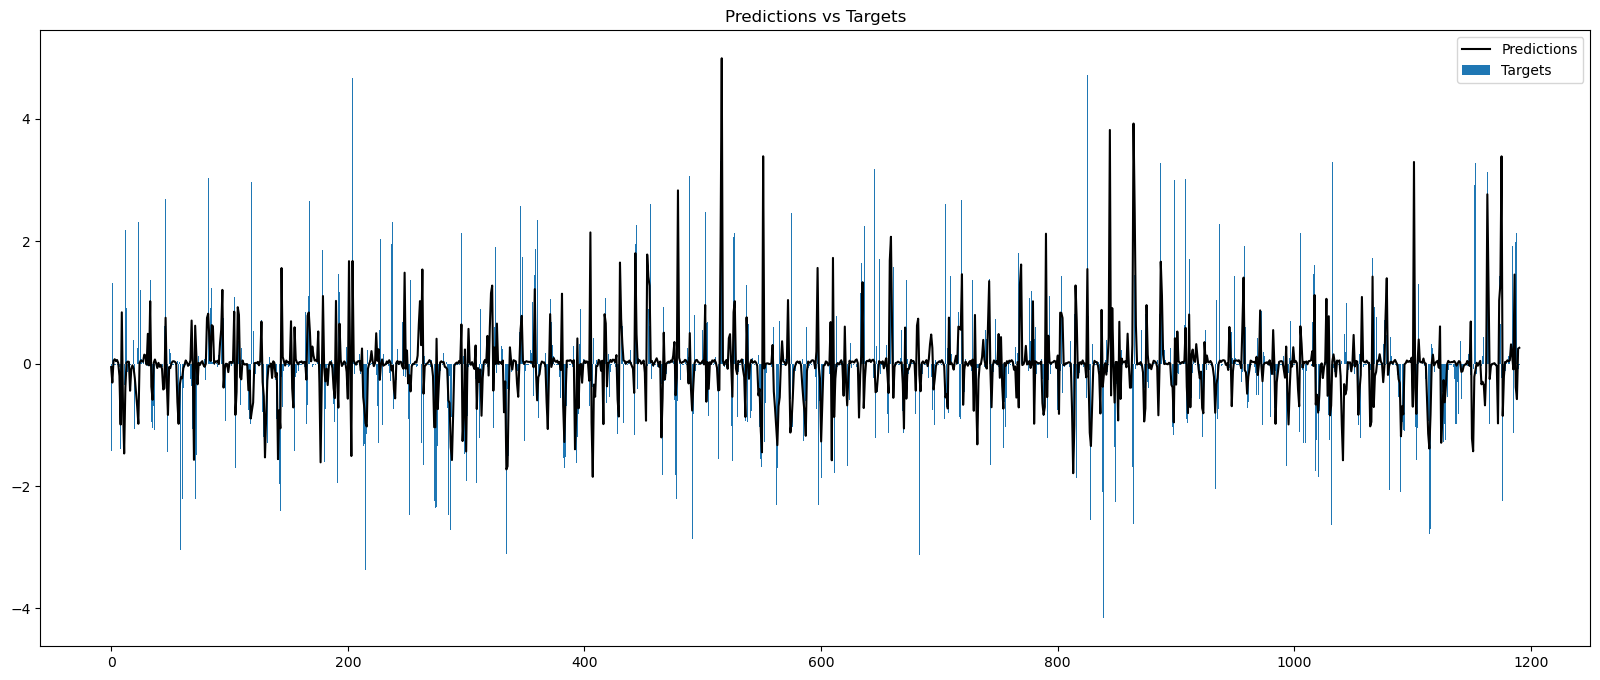

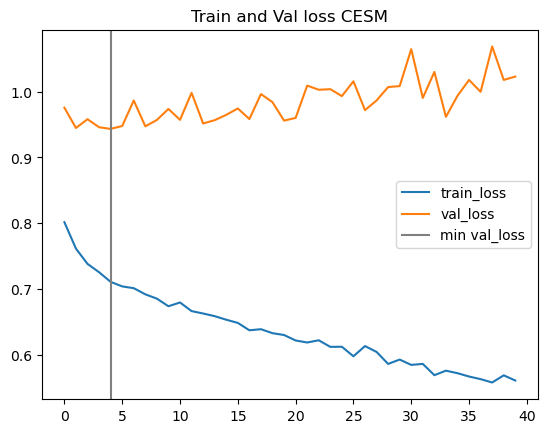

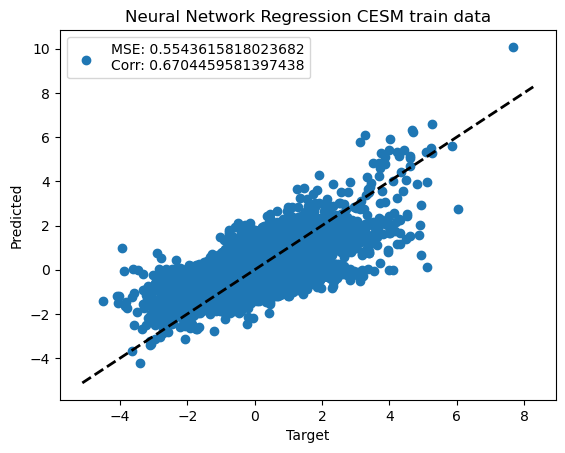

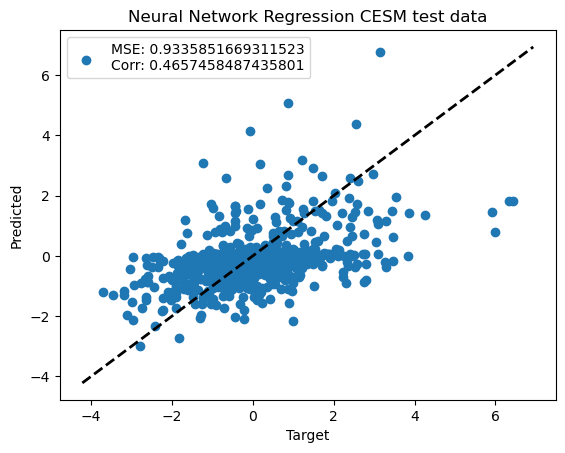

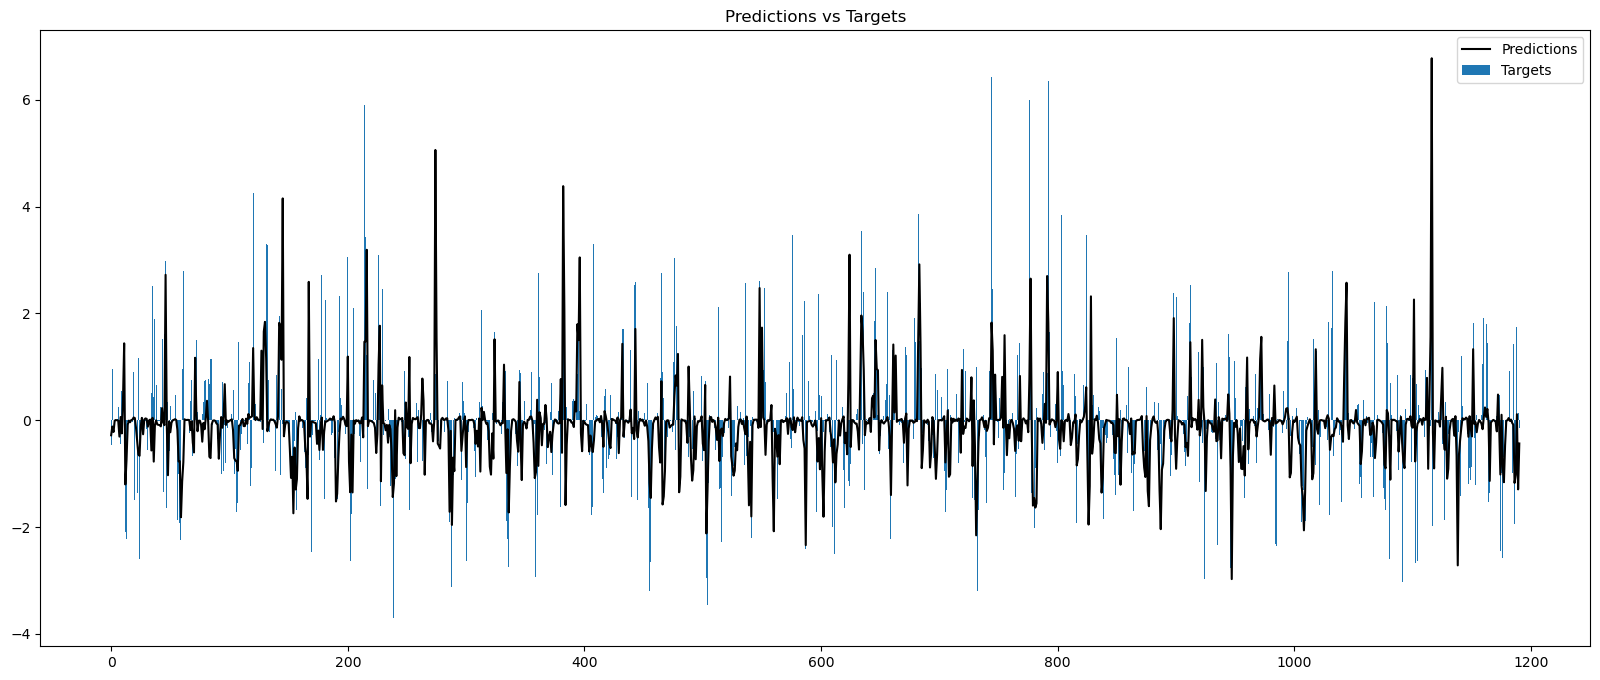

FOCI mse: 0.7005741000175476
FOCI corr: 0.4228259983538412


In [39]:
# Features
selected = ['SAT_N_LAND', 'SST_MED', 'SOI', 'NP', 'SAM_ZM', 'SST_HMDR', 'SSS_NA']
num_epochs = 40

torch.manual_seed(0)


data = Data(split=[0.8, 0.1, 0.1], lead_time=lead_time, seq_length=seq_length, flatten_seq=False, feature_list=selected)
input_len = len(data.train_input_FOCI[0]) if flatten_seq else len(data.train_input_FOCI[0][0]) 
model = RNN(input_len)
mse_foci, corr_foci = train_and_evaluate_model(model, data, num_epochs=num_epochs, learning_rate=learning_rate, weight_decay=weight_decay)

print('FOCI mse: {}\nFOCI corr: {}'.format(mse_foci, corr_foci))

## Performing forward feature selection using the RNN

In [63]:
def forward_selection_rnn(lead_time=0, seq_length=9):
    # Get feature ranking and min mse/max corr
    data = Data(split=[0.8, 0.1, 0.1], seq_length=seq_length, lead_time=lead_time)
    input_len = len(data.train_input_FOCI[0][0])
    best_model = RNN(input_len)
    init_mse, init_corr = train_and_evaluate_model(best_model, data, num_epochs=40, learning_rate=0.001, weight_decay=0)
    min_mse = float('inf')
    max_corr = float('-inf')
    feature_names = data.possible_features
    # Perform forward selection
    selection = []
    
    for name in feature_names:
        # Add new feature
        selection.append(name)
        
        data = Data(split=[0.8, 0.1, 0.1], seq_length=seq_length, feature_list=selection, lead_time=lead_time)
        input_len = len(data.train_input_FOCI[0][0])
        # Train model with selected features
        model = RNN(input_len)
        mse, corr = train_and_evaluate_model(model, data, num_epochs=40, learning_rate=0.001, weight_decay=0)
        
        # Performance check for correlation
        if corr > max_corr:
            print('Selected feature: {}'.format(name))
            best_model = model # Save model so we avoid retraining it for results
            max_corr = corr
            min_mse = mse # Update Mse for final output
        # No performance improvement
        else:
            print('Feature {} has not been selected.'.format(name))
            selection = selection[:-1]  # Remove feature from selection
    
    # Print out results
    data = Data(split=[0.8, 0.1, 0.1], seq_length=seq_length, feature_list=selection, lead_time=lead_time)
    clear_output()
    print('Selected features: {}'.format(selection))
    print('All feature performance:\nMSE:{}\nCorr:{}'.format(init_mse, init_corr))
    print('Selected feature performance:\nMSE:{}\nCorr:{}'.format(min_mse, max_corr))


In [64]:
forward_selection_rnn()

Selected features: ['AMO', 'ENSO_12', 'ENSO_3', 'ENSO_4', 'NAO_PC', 'SAM_ZM', 'SAT_N_ALL', 'SOI', 'SSS_ENA', 'SST_HMDR', 'SST_MED', 'SST_TNA', 'SST_TSA']
All feature performance:
MSE:0.6095187067985535
Corr:0.5363237447982149
Selected feature performance:
MSE:0.572721540927887
Corr:0.5495958067673404


# Comparing LSTM with all features to LSTM with RNN selected features


In [68]:
class LSTM(nn.Module):
    def __init__(self, num_in):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=num_in, hidden_size=28, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(28, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, 16)
        self.fc7 = nn.Linear(16, 16)
        self.fc8 = nn.Linear(16, 16)
        self.fc9 = nn.Linear(16, 8)
        self.fc10 = nn.Linear(8, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:,-1,:]

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.relu(self.fc8(x))
        x = self.relu(self.fc9(x))
        x = self.fc10(x)

        return x

## All features LSTM

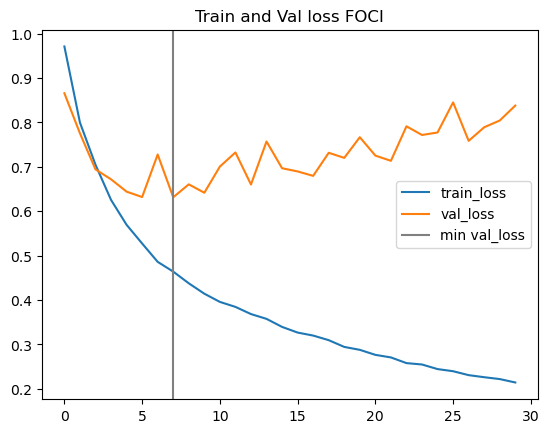

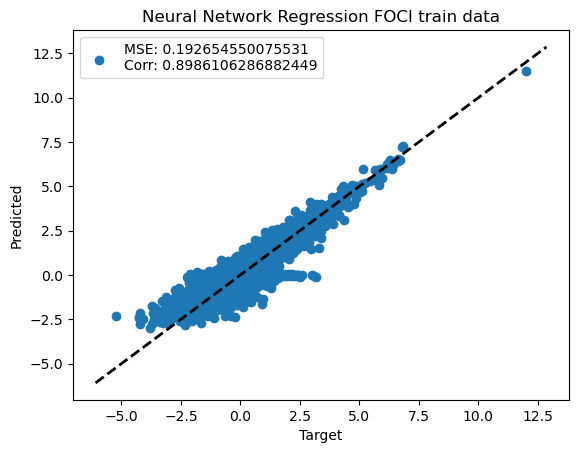

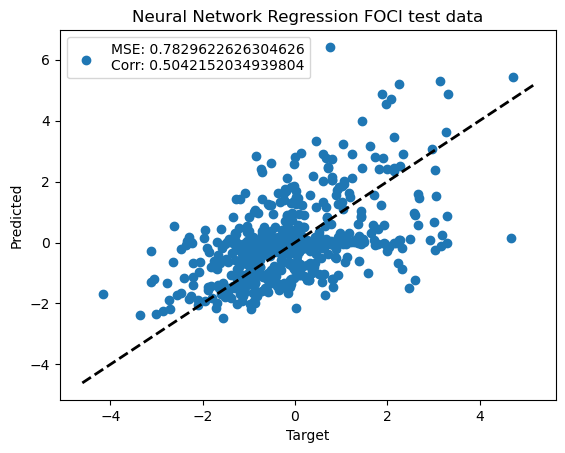

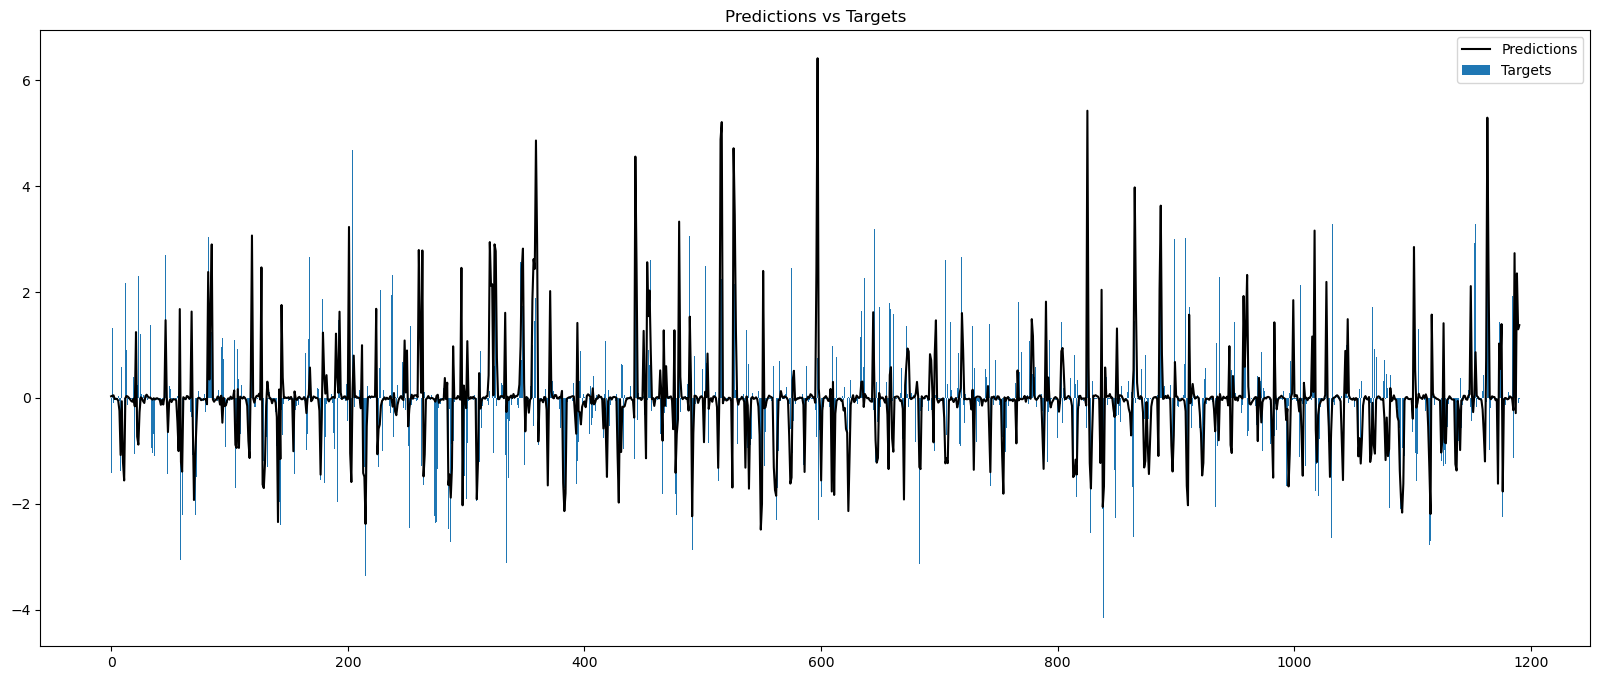

FOCI mse: 0.7829622626304626
 FOCI corr: 0.5042152034939804


In [69]:
torch.manual_seed(0)
lead_time = 0
seq_length = 9
flatten_seq = False
num_epochs = 30
learning_rate = 0.001
weight_decay = 0

# All features
data = Data(split=[0.8, 0.1, 0.1], lead_time=lead_time, seq_length=seq_length, flatten_seq=flatten_seq)
input_len = len(data.train_input_FOCI[0]) if flatten_seq else len(data.train_input_FOCI[0][0]) 
model = LSTM(input_len)
mse_foci, corr_foci = train_and_evaluate_model(model, data, num_epochs=num_epochs, learning_rate=learning_rate, weight_decay=weight_decay)

print('FOCI mse: {}\n FOCI corr: {}'.format(mse_foci, corr_foci))

## Feature selected LSTM

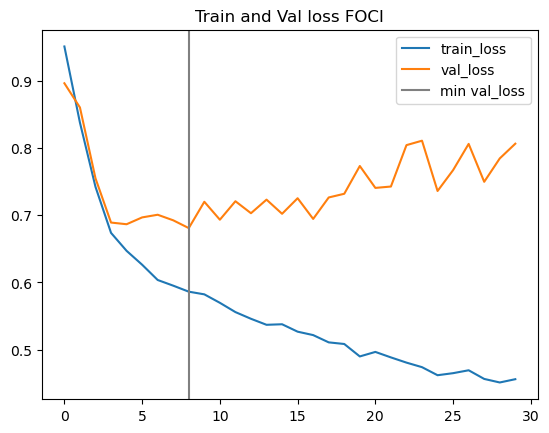

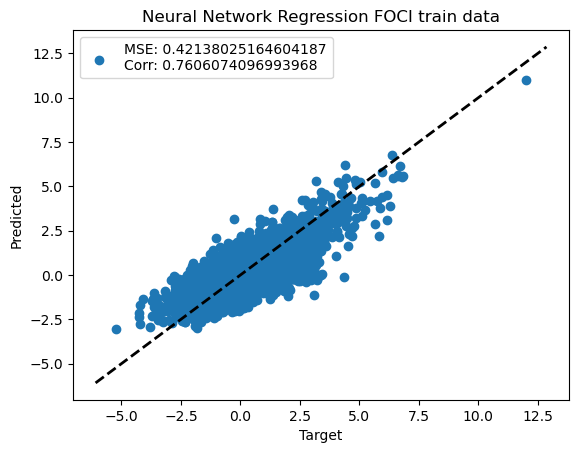

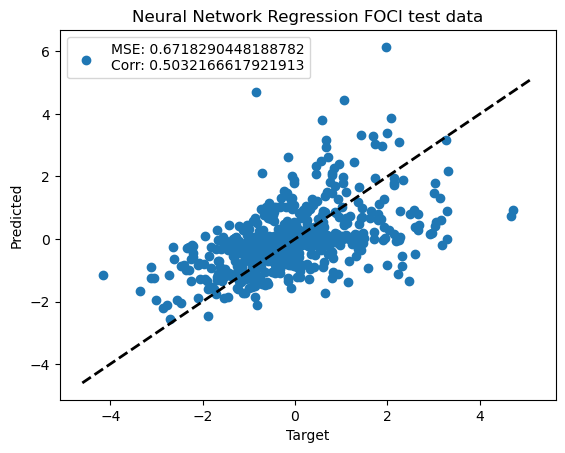

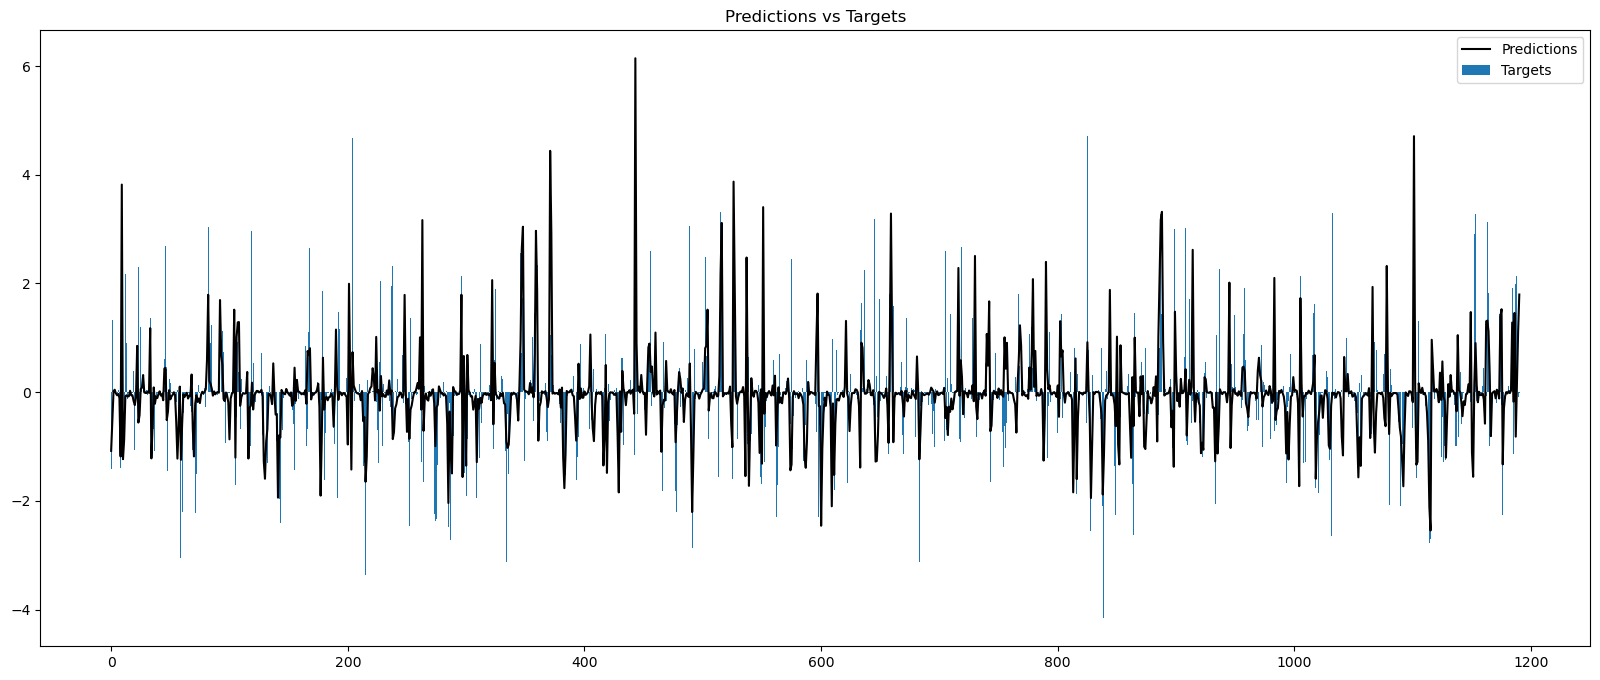

FOCI mse: 0.6718290448188782
FOCI corr: 0.5032166617921913


In [71]:
selection = ['AMO', 'ENSO_12', 'ENSO_3', 'ENSO_4', 'NAO_PC', 'SAM_ZM', 'SAT_N_ALL', 'SOI', 'SSS_ENA', 'SST_HMDR', 'SST_MED', 'SST_TNA', 'SST_TSA']



data = Data(split=[0.8, 0.1, 0.1], lead_time=lead_time, seq_length=seq_length, flatten_seq=False, feature_list=selection)
input_len = len(data.train_input_FOCI[0]) if flatten_seq else len(data.train_input_FOCI[0][0]) 
model = RNN(input_len)
mse_foci, corr_foci = train_and_evaluate_model(model, data, num_epochs=num_epochs, learning_rate=learning_rate, weight_decay=weight_decay)

print('FOCI mse: {}\nFOCI corr: {}'.format(mse_foci, corr_foci))

# Result
Feature selection seems to result in improvement however it is seemingly model dependend.
Selecting features using one model and using it for another seems to lower the performance of the model.
However selecting the features using one model and then using those selected features with the same model increases the performance.

Using RNN selected features for the LSTM lowers the MSE but also slightly lowers the correlation, which is unwanted behaviour. Using the RF selected features leads to way worse correlation but better MSE.

RNN selection for lead_time = 0:
['AMO', 'ENSO_12', 'ENSO_3', 'ENSO_4', 'NAO_PC', 'SAM_ZM', 'SAT_N_ALL', 'SOI', 'SSS_ENA', 'SST_HMDR', 'SST_MED', 'SST_TNA', 'SST_TSA']

RF selection for lead_time = 0:
['SAT_N_LAND', 'SST_MED', 'SOI', 'NP', 'SAM_ZM', 'SST_ESIO', 'AMO', 'SST_TNA', 'SSS_ENA', 'SSS_NA']